<a href="https://colab.research.google.com/github/AnandUgale/SimilarProductionDetection/blob/master/Anomaly_Detection_on_Sensor_Data_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install necessary packages
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow import set_random_seed
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from keras.layers import Input, Dense, Dropout, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

Using TensorFlow backend.


In [0]:
# set random seed
seed(10)
set_random_seed(10)

In [0]:
df_train = pd.read_csv('/content/data.csv')
df_test = pd.read_csv('/content/sample_20200212.csv')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28898 entries, 0 to 28897
Data columns (total 10 columns):
Timestamp                       28898 non-null int64
jobName                         28898 non-null object
values_PostStage                28898 non-null float64
values_MidStage                 28898 non-null float64
values_ConveyorBeltTimestamp    28898 non-null object
sourceName                      28898 non-null object
_timestamp                      28898 non-null object
_version                        28898 non-null int64
values_PreStage                 28898 non-null float64
Timestamp_HR                    28898 non-null object
dtypes: float64(3), int64(2), object(5)
memory usage: 2.2+ MB


In [5]:
df_train.nunique()

Timestamp                        2702
jobName                             1
values_PostStage                20158
values_MidStage                 20158
values_ConveyorBeltTimestamp        1
sourceName                          2
_timestamp                          1
_version                            1
values_PreStage                 20158
Timestamp_HR                     2702
dtype: int64

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149568 entries, 0 to 149567
Data columns (total 6 columns):
Timestamp           149568 non-null int64
values_PostStage    149568 non-null float64
values_MidStage     149568 non-null float64
sourceName          149568 non-null object
values_PreStage     149568 non-null float64
Timestamp_HR        149568 non-null object
dtypes: float64(3), int64(1), object(2)
memory usage: 6.8+ MB


In [7]:
df_test.nunique()

Timestamp            14941
values_PostStage    102954
values_MidStage     102942
sourceName               2
values_PreStage     102948
Timestamp_HR         14941
dtype: int64

In [8]:
df_test.head()

,Timestamp,values_PostStage,values_MidStage,sourceName,values_PreStage,Timestamp_HR
0,1581498216,89.642216,66.550189,sensors1,23.833349,09:03:36
1,1581498216,89.642216,66.550189,sensors2,23.833349,09:03:36
2,1581498216,92.055269,64.740733,sensors1,26.217064,09:03:36
3,1581498216,92.055269,64.740733,sensors2,26.217064,09:03:36
4,1581498216,89.879600,63.936600,sensors1,23.439999,09:03:36


In [0]:
df_train.drop(labels=['Timestamp', 'jobName', 'values_ConveyorBeltTimestamp', '_timestamp', '_version'], axis=1, inplace=True)
df_test.drop(labels=['Timestamp'], axis=1, inplace=True)

In [10]:
df_train.head()

,values_PostStage,values_MidStage,sourceName,values_PreStage,Timestamp_HR
0,92.595291,64.930687,sensors1,27.138446,2/7/2020 9:09:09
1,90.499815,64.402893,sensors2,25.619771,2/7/2020 9:09:09
2,89.024493,65.099289,sensors1,24.361520,2/7/2020 9:09:09
3,88.263517,64.992419,sensors2,25.840487,2/7/2020 9:09:09
4,88.099106,65.409816,sensors1,26.172290,2/7/2020 9:09:09


In [11]:
df_test.head()

,values_PostStage,values_MidStage,sourceName,values_PreStage,Timestamp_HR
0,89.642216,66.550189,sensors1,23.833349,09:03:36
1,89.642216,66.550189,sensors2,23.833349,09:03:36
2,92.055269,64.740733,sensors1,26.217064,09:03:36
3,92.055269,64.740733,sensors2,26.217064,09:03:36
4,89.879600,63.936600,sensors1,23.439999,09:03:36


In [0]:
df_train_new = df_train.groupby('Timestamp_HR', as_index=False)['values_PostStage', 'values_MidStage', 'values_PreStage'].mean()
df_test_new = df_test.groupby('Timestamp_HR', as_index=False)['values_PostStage', 'values_MidStage', 'values_PreStage'].mean()

In [13]:
df_train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2702 entries, 0 to 2701
Data columns (total 4 columns):
Timestamp_HR        2702 non-null object
values_PostStage    2702 non-null float64
values_MidStage     2702 non-null float64
values_PreStage     2702 non-null float64
dtypes: float64(3), object(1)
memory usage: 105.5+ KB


In [0]:
# set index
df_train_new.set_index('Timestamp_HR', inplace=True)

In [15]:
df_train_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2702 entries, 2/7/2020 9:09:09 to 2/7/2020 9:57:39
Data columns (total 3 columns):
values_PostStage    2702 non-null float64
values_MidStage     2702 non-null float64
values_PreStage     2702 non-null float64
dtypes: float64(3)
memory usage: 84.4+ KB


In [16]:
df_train_new.head()

,values_PostStage,values_MidStage,values_PreStage
Timestamp_HR,,,
2/7/2020 9:09:09,89.761779,64.819085,25.588651
2/7/2020 9:09:10,90.471943,64.696170,24.770616
2/7/2020 9:09:11,89.803776,65.278842,24.946765
2/7/2020 9:09:12,90.027319,64.789562,24.750992
2/7/2020 9:09:13,89.799183,65.006167,25.567681


In [0]:
df_train_new.to_csv('train.csv')

In [18]:
df_test_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14941 entries, 0 to 14940
Data columns (total 4 columns):
Timestamp_HR        14941 non-null object
values_PostStage    14941 non-null float64
values_MidStage     14941 non-null float64
values_PreStage     14941 non-null float64
dtypes: float64(3), object(1)
memory usage: 583.6+ KB


In [0]:
# set index
df_test_new.set_index('Timestamp_HR', inplace=True)

In [20]:
df_test_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14941 entries, 09:03:36 to 13:23:56
Data columns (total 3 columns):
values_PostStage    14941 non-null float64
values_MidStage     14941 non-null float64
values_PreStage     14941 non-null float64
dtypes: float64(3)
memory usage: 466.9+ KB


In [21]:
df_test_new.head()

,values_PostStage,values_MidStage,values_PreStage
Timestamp_HR,,,
09:03:36,90.525695,65.075841,24.496804
09:03:37,90.269717,65.685547,25.055277
09:03:38,90.557231,65.217507,24.906444
09:03:39,89.820049,65.187712,24.694706
09:03:40,89.682135,64.897121,24.780168


In [0]:
df_test_new.to_csv('test.csv')

In [0]:
# Define train and test dataset
df_train_new.drop(labels=['values_MidStage', 'values_PreStage'], axis=1, inplace=True)
df_test_new.drop(labels=['values_MidStage', 'values_PreStage'], axis=1, inplace=True)

In [25]:
df_train_new.head()

,values_PostStage
Timestamp_HR,
2/7/2020 9:09:09,89.761779
2/7/2020 9:09:10,90.471943
2/7/2020 9:09:11,89.803776
2/7/2020 9:09:12,90.027319
2/7/2020 9:09:13,89.799183


In [26]:
df_test_new.head()

,values_PostStage
Timestamp_HR,
09:03:36,90.525695
09:03:37,90.269717
09:03:38,90.557231
09:03:39,89.820049
09:03:40,89.682135


In [0]:
# split into train and test split
train = df_train_new
val = df_test_new

In [28]:
train.shape, val.shape

((2702, 1), (14941, 1))

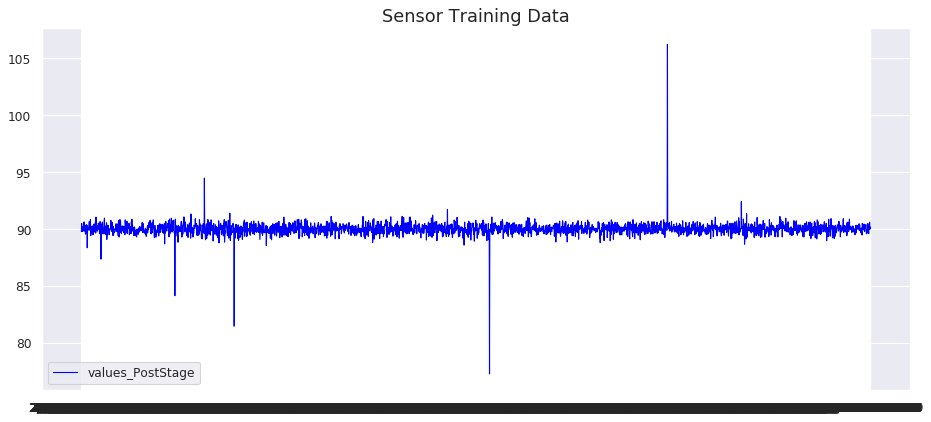

In [29]:
# Only fot values_PostStage
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['values_PostStage'], label='values_PostStage', color='blue', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sensor Training Data', fontsize=16)
plt.show()

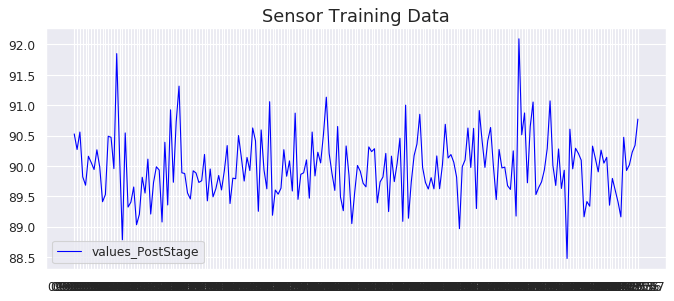

In [31]:
# Only fot values_PostStage
fig, ax = plt.subplots(figsize=(10, 4), dpi=80)
ax.plot(val['values_PostStage'][:200], label='values_PostStage', color='blue', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sensor Training Data', fontsize=16)
plt.show()

In [0]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
val_fft = np.fft.fft(val)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Unrecognized location 'top left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  This is separate from the ipykernel package so we can avoid doing imports until


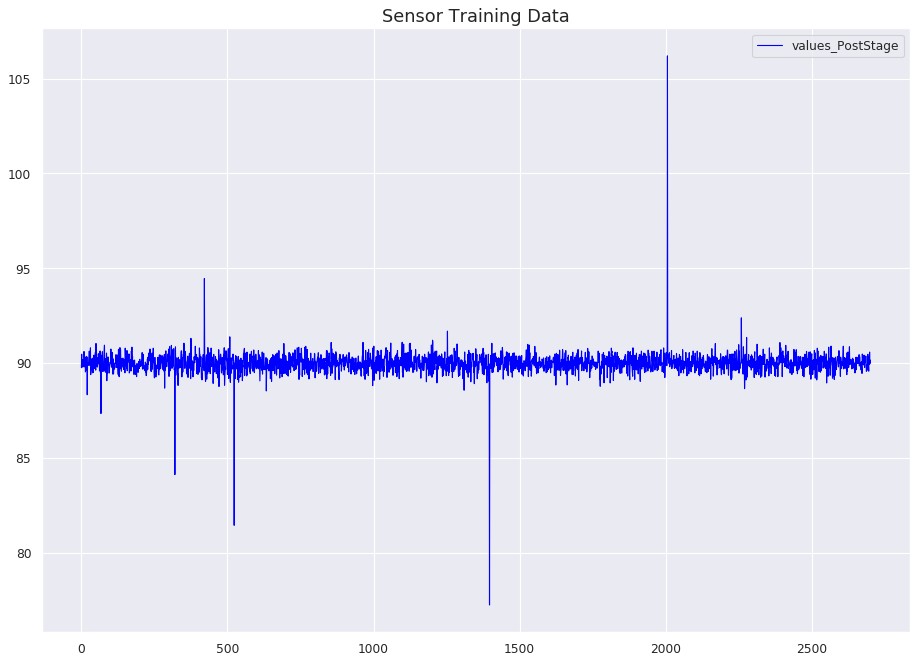

In [33]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 10), dpi=80)
ax.plot(train_fft[:,0], label='values_PostStage', color='blue', animated = True, linewidth=1)
plt.legend(loc='top left')
ax.set_title('Sensor Training Data', fontsize=16)
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


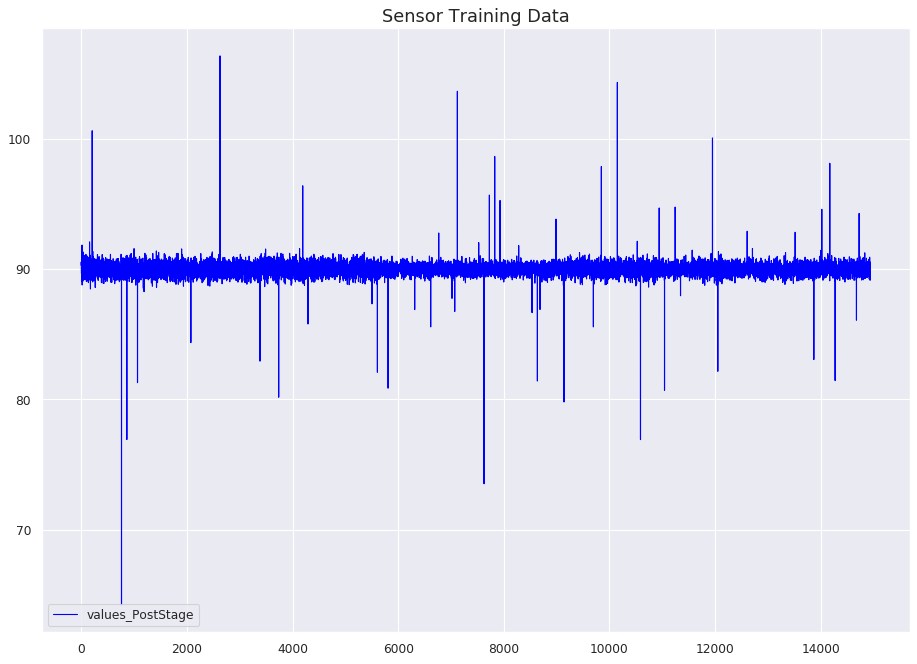

In [34]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 10), dpi=80)
ax.plot(val_fft[:,0], label='values_PostStage', color='blue', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sensor Training Data', fontsize=16)
plt.show()

In [35]:
# first normalize it to a range between 0 and 1.
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_val = scaler.transform(val)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [36]:
X_train.shape

(2702, 1)

In [37]:
X_val.shape

(14941, 1)

In [38]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
print("Test data shape:", X_val.shape)

Training data shape: (2702, 1, 1)
Test data shape: (14941, 1, 1)


In [0]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [40]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             1152      
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 1)              17  

In [41]:
# fit the model to the data
nb_epochs = 30
batch_size = 100
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Train on 2566 samples, validate on 136 samples
Epoch 1/30
2566/2566 [==============================] - 12s 5ms/step - loss: 0.4259 - val_loss: 0.4092
Epoch 2/30
2566/2566 [==============================] - 0s 149us/step - loss: 0.3919 - val_loss: 0.3732
Epoch 3/30
2566/2566 [==============================] - 0s 158us/step - loss: 0.3533 - val_loss: 0.3309
Epoch 4/30
2566/2566 [==============================] - 0s 161us/step - loss: 0.3067 - val_loss: 0.2790
Epoch 5/30
2566/2566 [==============================] - 0s 152us/step - loss: 0.2488 - val_loss: 0.2135
Epoch 6/30
2566/2566 [==============================] - 0s 156us/step - loss: 0.1747 - val_loss: 0.1280
Epoch 7/30
2566/2566 [==============================] - 0s 154us/step - loss: 0.0755 - val_loss: 0.0122
Epoch 8/30
2566/2566 [==============================] - 0s 163us/step - loss: 0.0142 - val_loss: 0.0108
Epoch 9/30
2566/2566 [==============================] - 0s 163us/step - loss: 0.0117 - val_loss: 0.0082
Epoch 10/30
2566/2

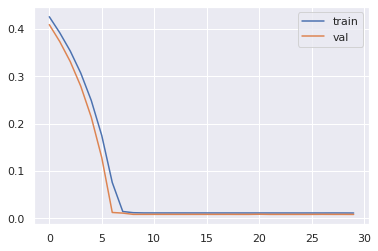

In [42]:
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend();

In [0]:
# Finding Anomalies
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

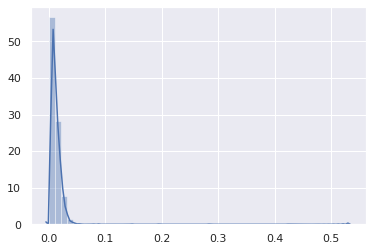

In [44]:
# look at the error:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [0]:
THRESHOLD = 0.03

In [0]:
# Let’s calculate the MAE on the test data:
X_val_pred = model.predict(X_val)

val_mae_loss = np.mean(np.abs(X_val_pred - X_val), axis=1)

In [0]:
# We’ll build a DataFrame containing the loss and the anomalies (values above the threshold):
val_score_df = pd.DataFrame(index=val.index)
val_score_df['loss'] = val_mae_loss
val_score_df['threshold'] = THRESHOLD
val_score_df['anomaly'] = val_score_df.loss > val_score_df.threshold
val_score_df['values_PostStage'] = val.values_PostStage

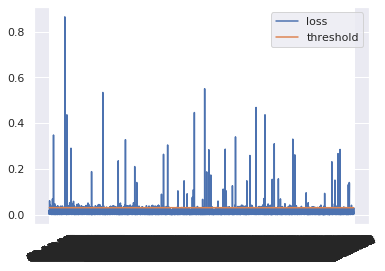

In [48]:
plt.plot(val_score_df.index, val_score_df.loss, label='loss')
plt.plot(val_score_df.index, val_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [49]:
# Looks like we’re thresholding extreme values quite well. Let’s create a DataFrame using only those:
anomalies = val_score_df[val_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,values_PostStage
Timestamp_HR,,,,
09:13:29,0.060315,0.03,True,91.848195
09:13:31,0.041035,0.03,True,88.783317
09:13:36,0.032823,0.03,True,89.031244
09:13:45,0.031320,0.03,True,89.076629
09:15:15,0.042639,0.03,True,91.312828


In [0]:
plt.plot(
  val.index, 
  val.values_PostStage, 
  label='values_PostStage'
);

sns.scatterplot(
  anomalies.index,
  anomalies.values_PostStage,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();